Neste ficheiros exploramos o impacto da aplicação de data augmentation ao pré-processamento do modelo I

# Imports and Configurations

In [128]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [129]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [130]:
# Paths
pathTrain = '../train_images/GTSRB/Final_Training/Images'
pathTest = '../test_images'

# Batch size - It can influence speed and generalization, not necessarily in the same direction. 
# There is no golden rule for the batch size but 32 is a commom number to start with.
BATCH_SIZE = 32

IMAGE_SIZE = 32
EPOCHS = 20

# Auxiliary Functions

In [131]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()

# Prepare and Load Data

In [132]:
# Convert the images from ppm to png
from PIL import Image
import glob
def ppm2png():
    images = glob.glob(f'{pathTrain}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)

    images = glob.glob(f'{pathTest}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)
#ppm2png()

Aqui tratamos de aplicar data augmentation enquanto pré-processamento. Nomeadamente através da transformação resize já previamente utilizada e da transformação random contrast.

In [133]:
from torchvision.transforms import v2

transform = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomAutocontrast(p=1.0),          # Apply autocontrast to the image
    v2.ToImage(),                          # Convert to tensor
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [134]:
train_set = torchvision.datasets.ImageFolder(root=pathTrain, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=pathTest, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [137]:
# Print the number of images in each class of the training set
for i, c in enumerate(train_set.classes):
    print(f'{c}: {len(os.listdir(os.path.join(pathTrain, c)))}')
print(f'Total: {len(train_set)}')

00000: 211
00001: 2221
00002: 2251
00003: 1411
00004: 1981
00005: 1861
00006: 421
00007: 1441
00008: 1411
00009: 1471
00010: 2011
00011: 1321
00012: 2101
00013: 2161
00014: 781
00015: 631
00016: 421
00017: 1111
00018: 1201
00019: 211
00020: 361
00021: 331
00022: 391
00023: 511
00024: 271
00025: 1501
00026: 601
00027: 241
00028: 541
00029: 271
00030: 451
00031: 781
00032: 241
00033: 690
00034: 421
00035: 1201
00036: 391
00037: 211
00038: 2071
00039: 301
00040: 361
00041: 241
00042: 241
Total: 39209


In [138]:
# Print the number of images in each class of the test set
for i, c in enumerate(test_set.classes):
    print(f'{c}: {len(os.listdir(os.path.join(pathTest, c)))}')
print(f'Total: {len(test_set)}')

00000: 60
00001: 720
00002: 750
00003: 450
00004: 660
00005: 630
00006: 150
00007: 450
00008: 450
00009: 480
00010: 660
00011: 420
00012: 690
00013: 720
00014: 270
00015: 210
00016: 150
00017: 360
00018: 390
00019: 60
00020: 90
00021: 90
00022: 120
00023: 150
00024: 90
00025: 480
00026: 180
00027: 60
00028: 150
00029: 90
00030: 150
00031: 270
00032: 60
00033: 210
00034: 120
00035: 390
00036: 120
00037: 60
00038: 690
00039: 90
00040: 90
00041: 60
00042: 90
Total: 12630


In [139]:
images, targets = next(iter(train_loader))
print("Batch shape: ", images.shape) # [batch_size, channels, height, width]
print(targets) 

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([31, 38, 33, 22, 25, 27, 37,  5, 12, 11, 25, 13,  4,  9,  2,  1, 38, 13,
        18, 36, 33, 35,  9,  2, 12, 35,  9,  4, 18, 25, 17, 38])


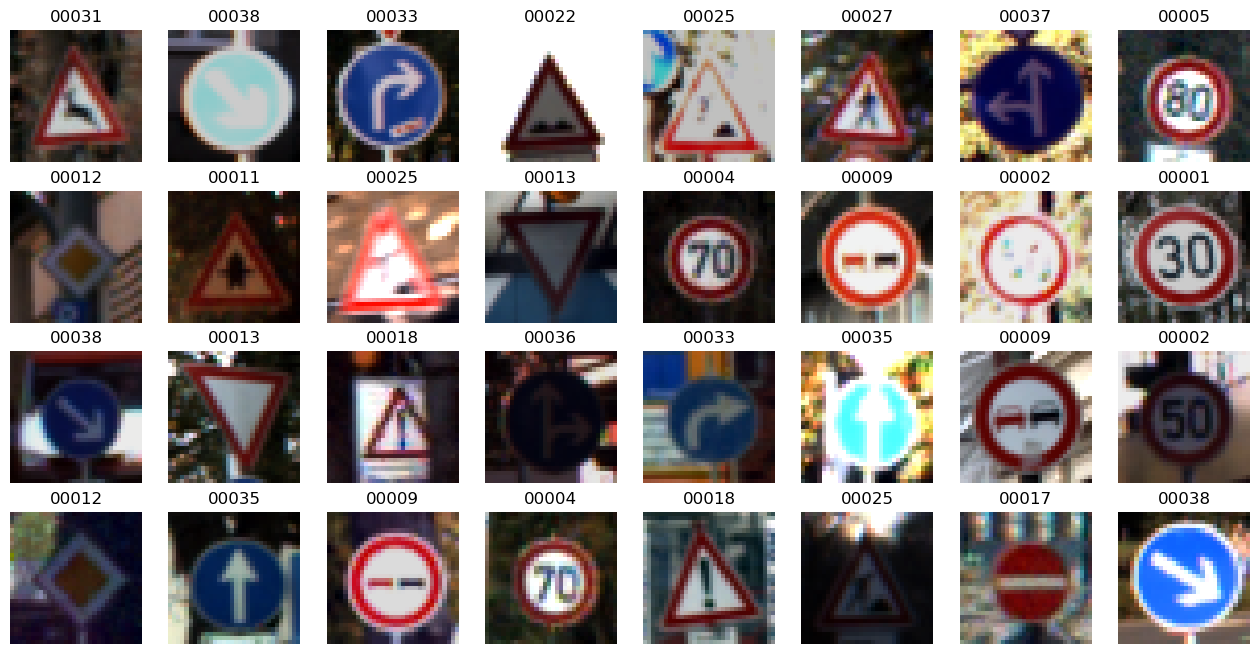

<Figure size 640x480 with 0 Axes>

In [140]:
vcpi_util.show_images(4,8,images, targets, train_set.classes)

# Treino

In [141]:
class Conv(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 16, 3) # 3 canais de entrada (porque as imagens são cores), 16 canais de saída, kernel 3x3  
        self.bn1 = torch.nn.BatchNorm2d(16)    
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)   # kernel 2x2, a imagem é reduzida para metade

        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)        
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)  # kernel 2x2, a imagem é novamente reduzida para metade

        self.fc1 = torch.nn.Linear(1200,num_classes) 

    def forward(self, x):
        # input = (batch_size, 3, 32, 32)
        x = self.conv1(x)                  # output = (batch_size, 16, 30, 30)  
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)                  # output = (batch_size, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.maxpool1(x)               # output = (batch_size, 32, 14, 14)

        x = self.conv3(x)                  # output = (batch_size, 48, 12, 12)                     
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)                  # output = (batch_size, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.maxpool2(x)               # output = (batch_size, 48, 5, 5)     45 x 5 x 5 = 1200

        x = torch.flatten(x, 1)             
        x = self.fc1(x)                                                                                     

        return x 
    
model_I = Conv(len(train_set.classes))
model_I.to(device)
print(model_I)

torchinfo.summary(model_I, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Conv(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=43, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [32, 43]                  --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

In [142]:
def train(model, train_loader, test_loader,epochs, loss_fn, optimizer):
    history = {}
    history['accuracy'] = []
    history['test_acc'] = []
    history['loss'] = []

    for epoch in range(epochs):
        start_time = time.time()

        correct = 0
        running_loss = 0

        for i, (inputs, targets) in enumerate(train_loader,0):
            # send data to the GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)

            # calcula o maximo dos outputs na dimensao 1 e devolve o maximo e o seu indice(indice da classe)
            _, predicted = torch.max(outputs, 1)             

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)

            # os gradientes de cada iteração são zerados para que não passem para a próxima iteração
            optimizer.zero_grad()                            

            # perform backpropagation
            loss.backward()

            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()

        with torch.no_grad():    
            t_correct = 0
            for i,t in test_loader:
                i, t = i.to(device), t.to(device)
                o = model(i)
                _, p = torch.max(o, 1)

                t_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Accuracy_Test: {t_accuracy:0.4f} ; Time: {(stop_time - start_time):0.4f}')
        
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')

    return history
            

In [143]:
optimizer_I = torch.optim.Adam(model_I.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

history_I = train(model_I,train_loader,test_loader,EPOCHS,loss_fn,optimizer_I)

Epoch 000; Loss: 0.0073; Accuracy: 94.3202; Accuracy_Test: 96.6825 ; Time: 76.9383
Epoch 001; Loss: 0.0015; Accuracy: 98.6534; Accuracy_Test: 95.8512 ; Time: 70.2324
Epoch 002; Loss: 0.0009; Accuracy: 99.1456; Accuracy_Test: 96.9675 ; Time: 70.0075
Epoch 003; Loss: 0.0007; Accuracy: 99.3420; Accuracy_Test: 95.9224 ; Time: 67.9373
Epoch 004; Loss: 0.0007; Accuracy: 99.4032; Accuracy_Test: 96.0095 ; Time: 63.1432
Epoch 005; Loss: 0.0006; Accuracy: 99.4619; Accuracy_Test: 95.5661 ; Time: 63.4204
Epoch 006; Loss: 0.0006; Accuracy: 99.5435; Accuracy_Test: 95.6453 ; Time: 63.0266
Epoch 007; Loss: 0.0005; Accuracy: 99.6072; Accuracy_Test: 96.4608 ; Time: 63.4635
Epoch 008; Loss: 0.0006; Accuracy: 99.4950; Accuracy_Test: 97.0230 ; Time: 63.4680
Epoch 009; Loss: 0.0004; Accuracy: 99.6531; Accuracy_Test: 96.8567 ; Time: 63.2445
Epoch 010; Loss: 0.0004; Accuracy: 99.6863; Accuracy_Test: 95.3127 ; Time: 63.4982
Epoch 011; Loss: 0.0003; Accuracy: 99.7246; Accuracy_Test: 97.0625 ; Time: 62.9797
Epoc

# Análise dos Resultados

Verificação do histórico de accuracy dos datasets de treino e de teste e do histórico de loss

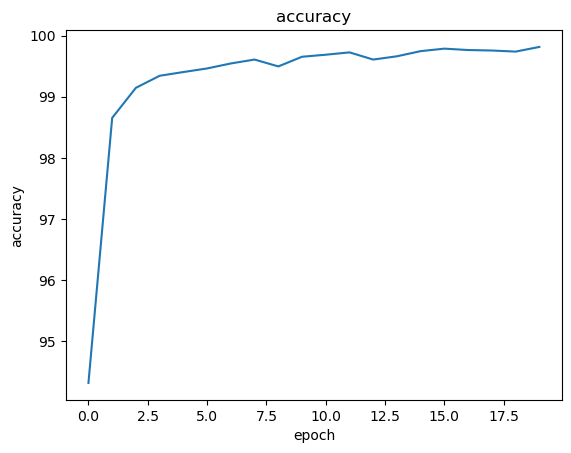

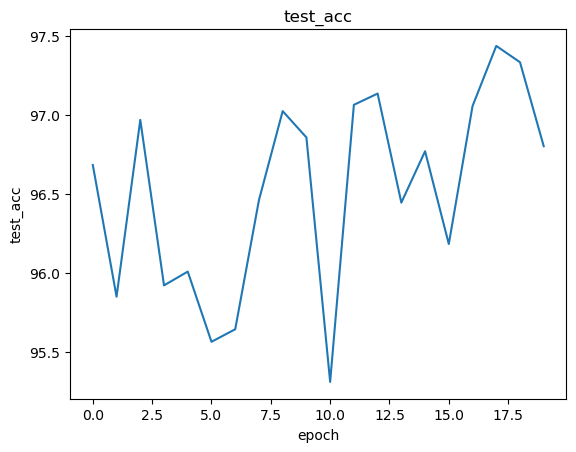

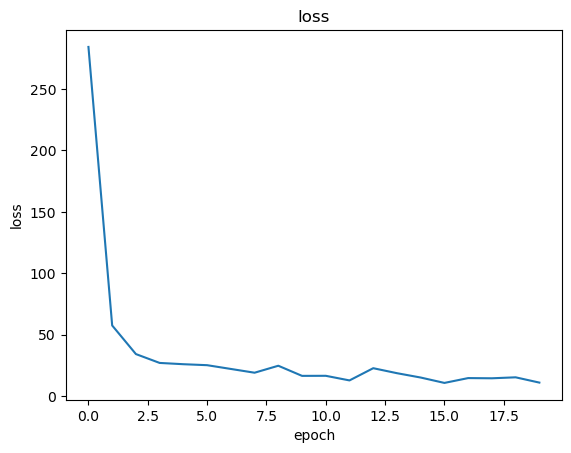

In [145]:
vcpi_util.show_history(history_I)

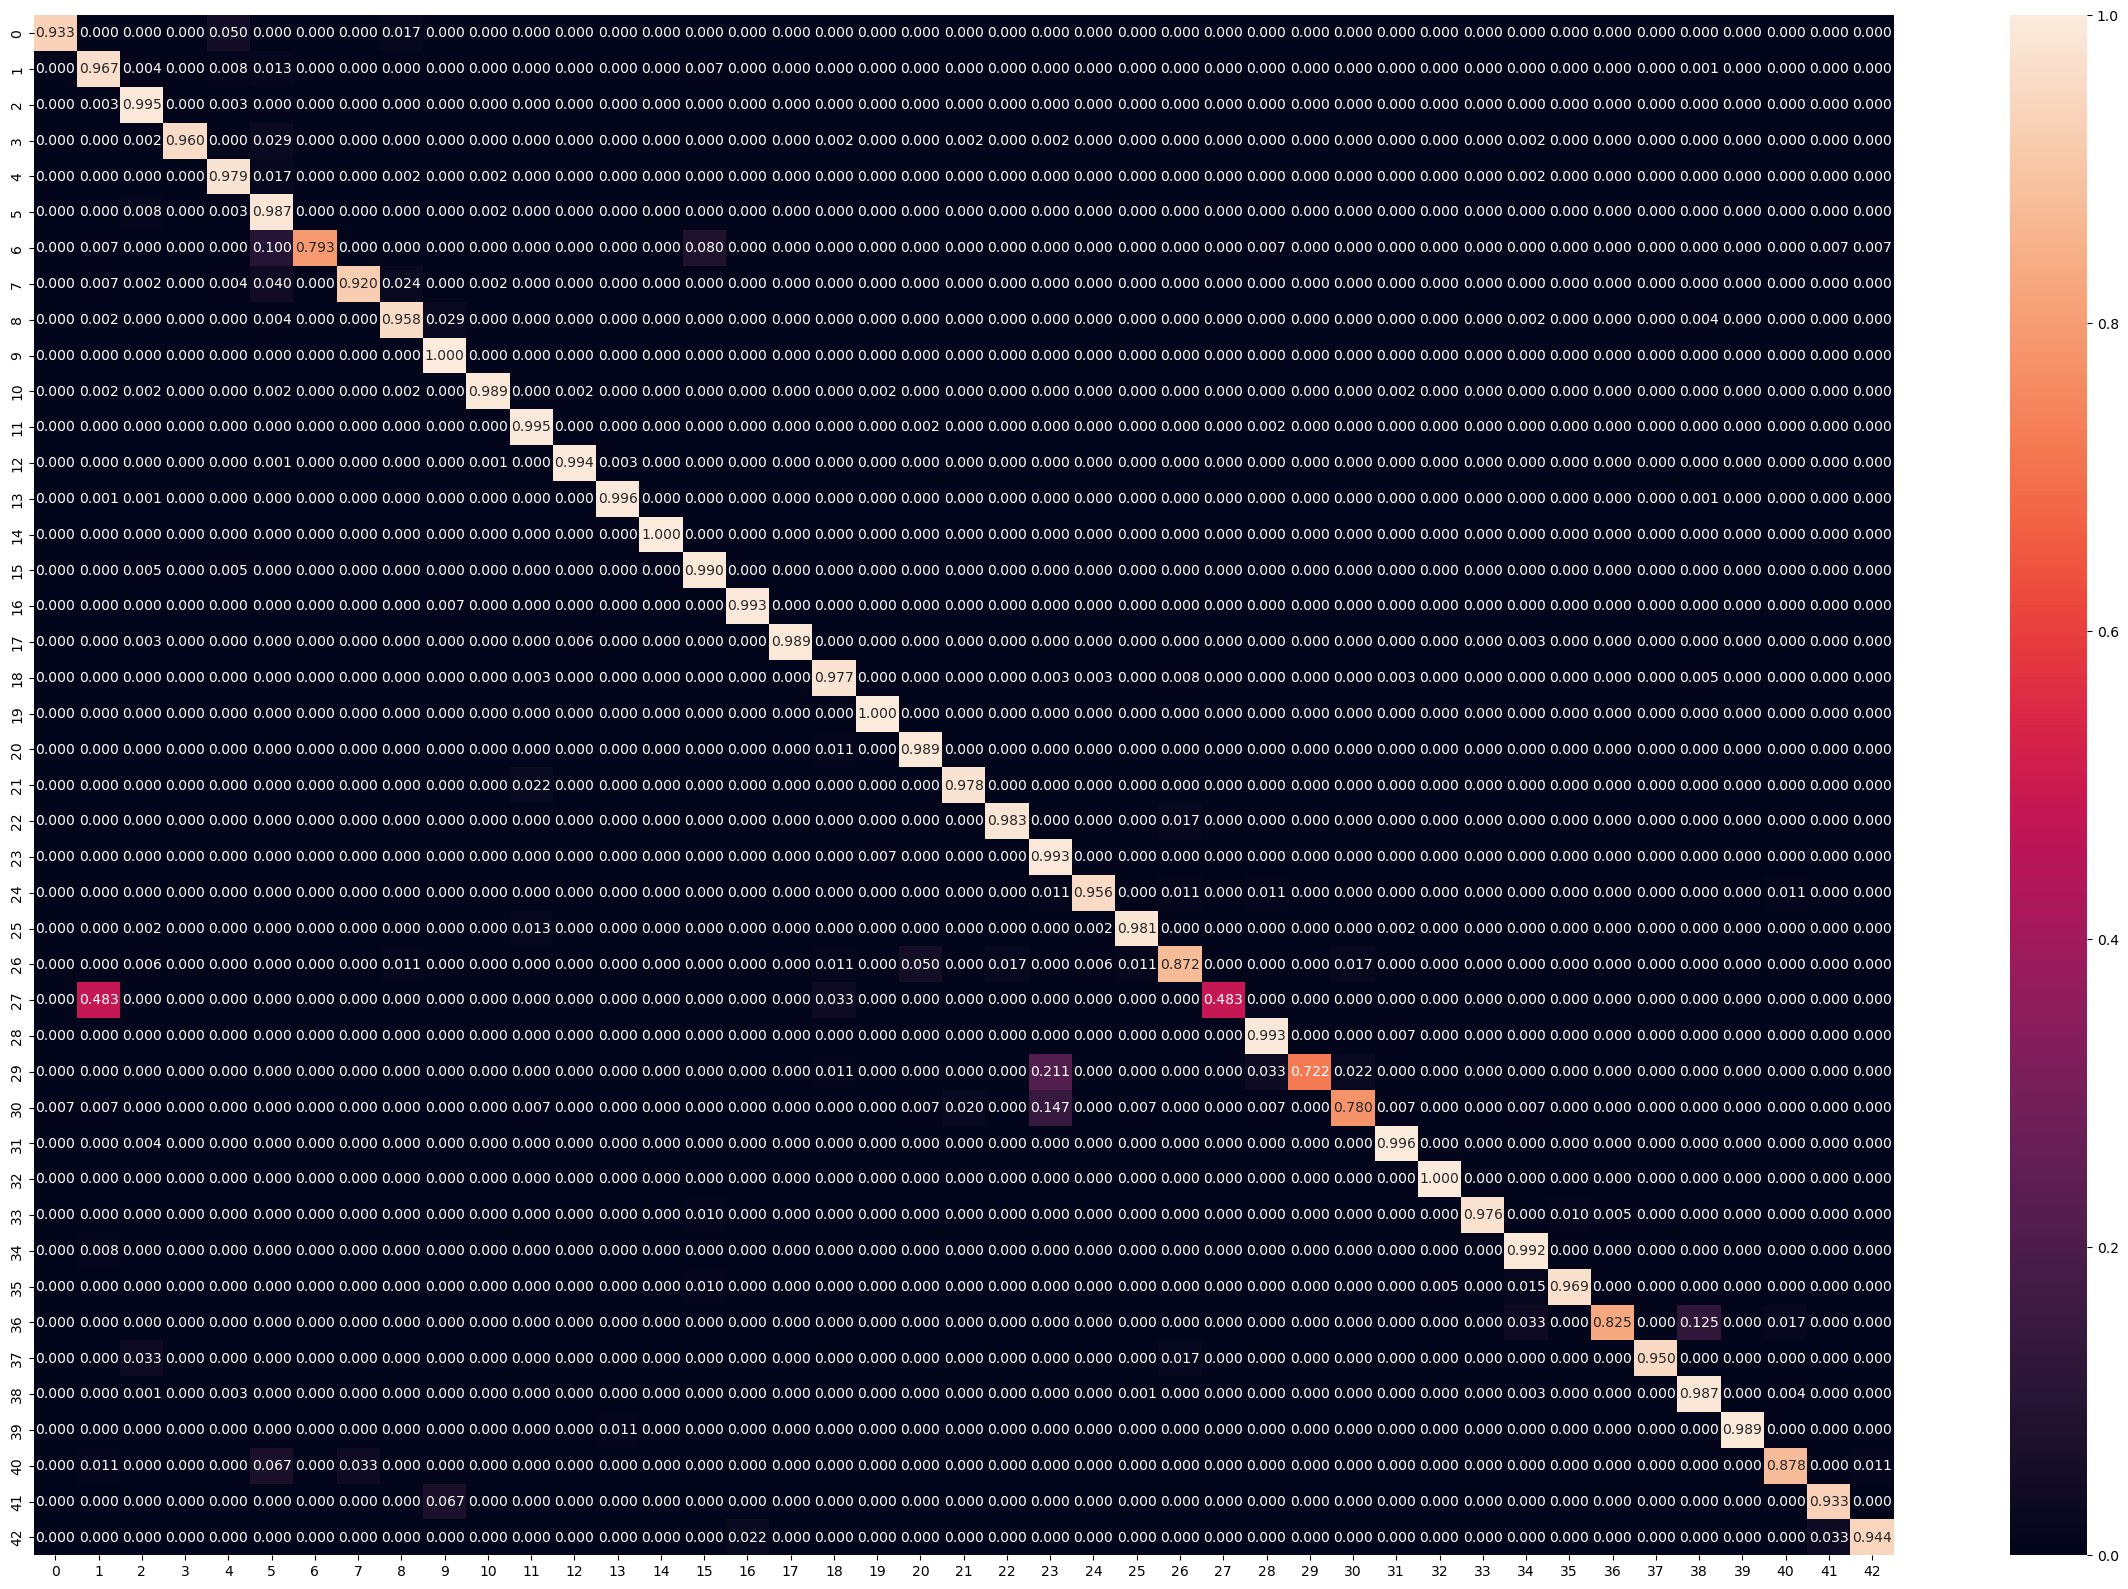

In [146]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model_I(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux) 
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, len(train_set.class_to_idx))

A partir da matriz de correlação acima criada podemos observar que as classes 27 e 29 foram as que obtiveram piores resultados em termos de accuracy.

Verificação das imagens mal classificadas

In [148]:
def show_bad_preds(model, dataset, classes):
    k = 0
    iters = 0

    preds = []
    ground_truth = []
    imgs = torch.Tensor(BATCH_SIZE, 3, IMAGE_SIZE,IMAGE_SIZE)

    iterator = iter(dataset)

    max_iters = test_set.__len__() / BATCH_SIZE
    while k < 32 and iters < max_iters:

        images, targets = next(iterator)
        #print(images[0].shape)
        logits = model(images.to(device))
        
        #print(predictions[0])
        predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
        for i in range(len(predictions)):

            if np.argmax(predictions[i]) != targets[i] and k < 32:

                preds.append(predictions[i])
                ground_truth.append(targets[i])
                imgs[k, :, :, :] = images[i]
                k += 1

        iters += 1

    vcpi_util.plot_predictions(imgs, preds, ground_truth, classes, 10, 3)

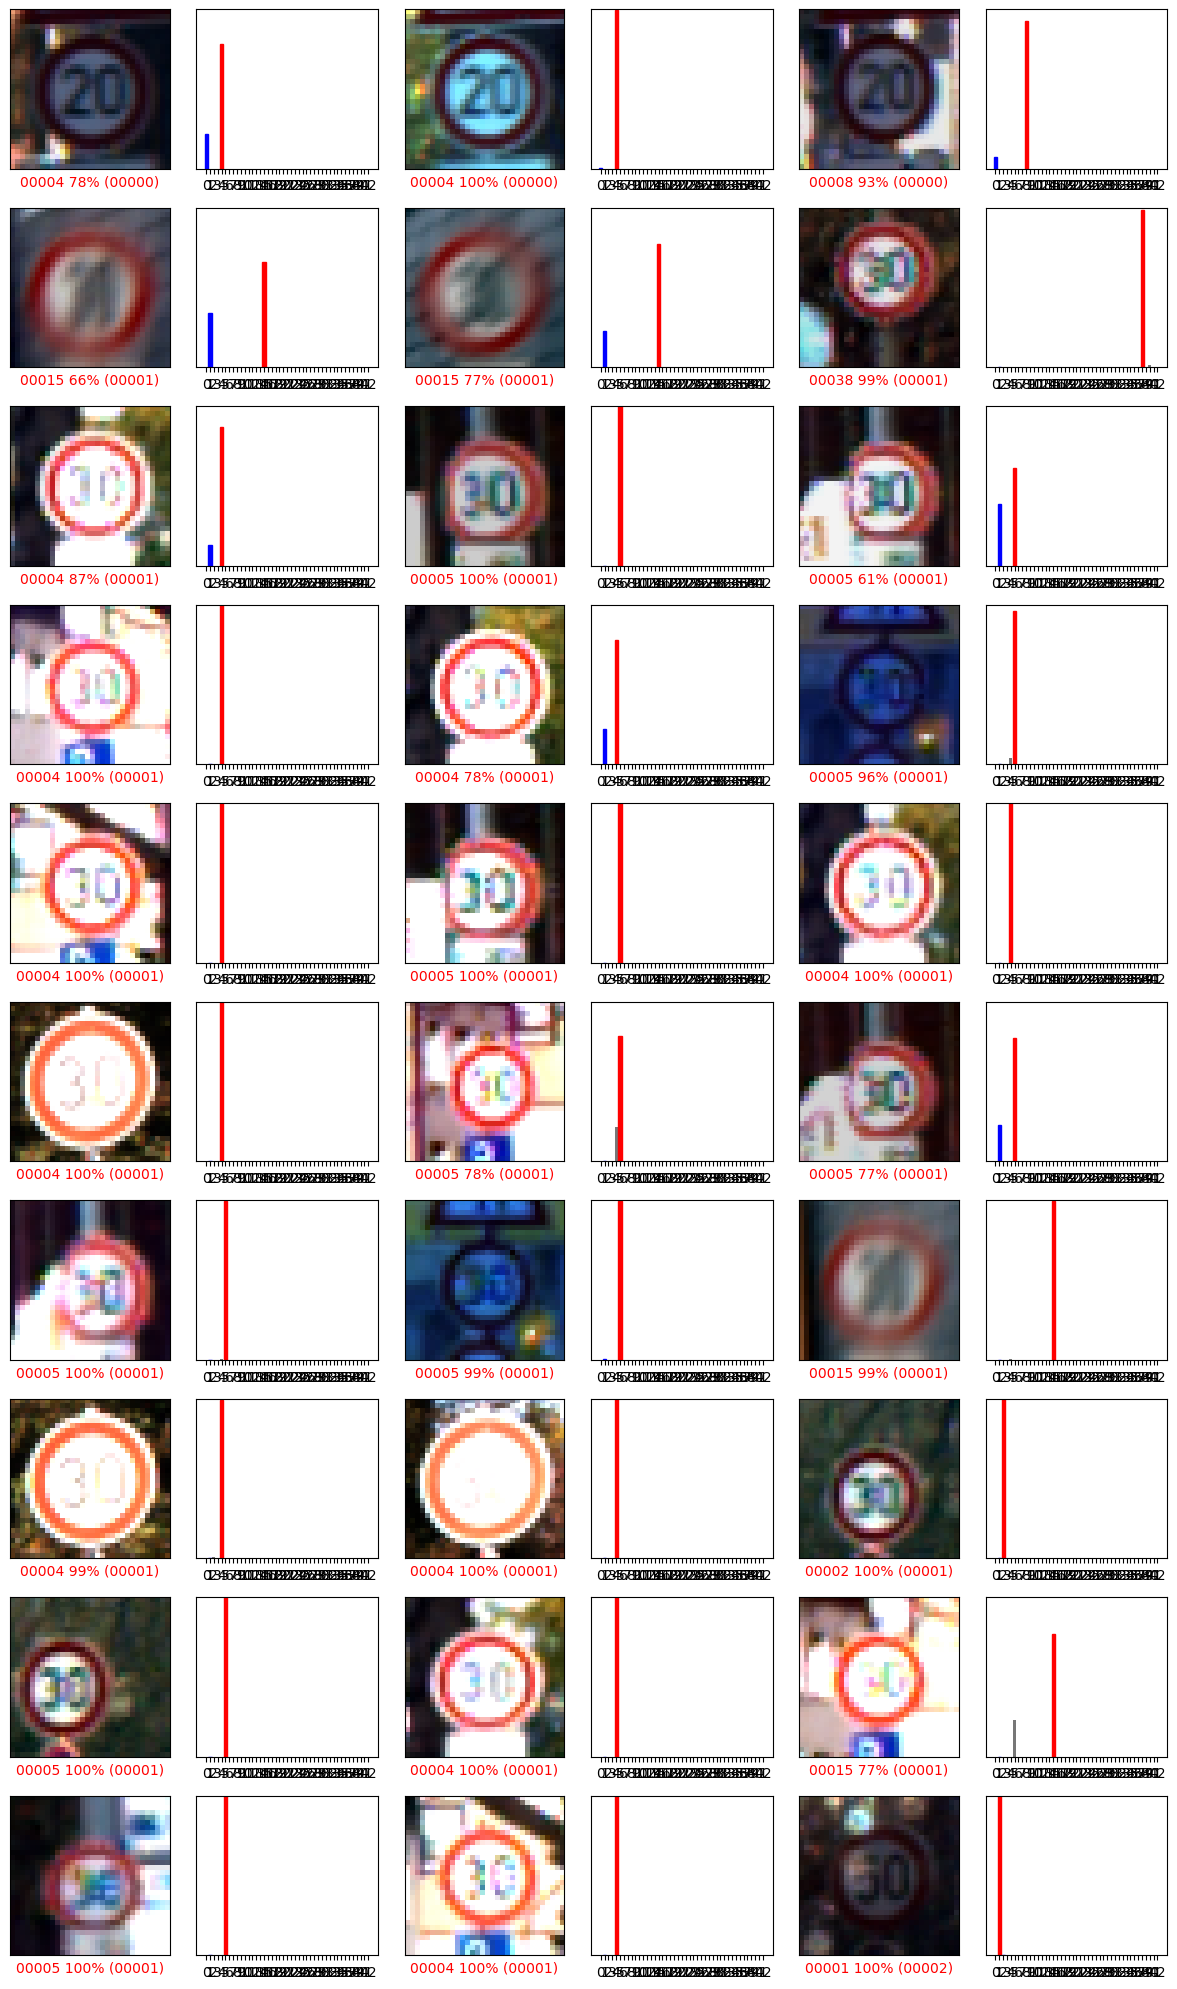

In [149]:
show_bad_preds(model_I, test_loader, test_set.classes)